In [38]:
import os
from datetime import datetime
from functools import partial

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [39]:
def scale(x):
    return (x - x.min()) / (x.max() - x.min())


def clip_scale(x, min=None, max=None):
    return scale(torch.clip(x, min, max))


def scale_clip(x, min=None, max=None):
    return torch.clip(scale(x), min, max)


# Function to update the frame
def update_frame_mazes(
    i,
    ax,
    sample,
    transform=partial(clip_scale, min=0),
    alpha_x=0.5,
    alpha_pyr=0.5,
    alpha_inter=0.5,
):
    blank = torch.zeros(3, *sample["x"].shape[-2:])

    # Maze image
    im_maze = sample["x"].squeeze()[:3].permute(1, 2, 0).numpy()

    # Start/Goal image
    im_start_goal = blank.clone()
    im_start_goal[2] = sample["x"].squeeze()[3]
    im_start_goal = im_start_goal.permute(1, 2, 0).numpy()

    # Pyramidal neuron activation image
    h_pyrs = sample["h_pyrs"][-1].squeeze()
    im_pyr = blank.clone()
    im_pyr[1] = transform(h_pyrs[i].sum(dim=0))
    im_pyr = im_pyr.permute(1, 2, 0).numpy()

    # Interneuron activation image
    h_inters = sample["h_inters"][-1].squeeze()
    im_inter = blank.clone()
    im_inter[0] = transform(h_inters[i].sum(dim=0))
    im_inter = im_inter.permute(1, 2, 0).numpy()

    ax.clear()
    if alpha_x > 0:
        ax.imshow(im_maze, alpha=alpha_x)
        ax.imshow(im_start_goal, alpha=alpha_x)
    if alpha_pyr > 0:
        ax.imshow(im_pyr, alpha=alpha_x)
    if alpha_inter:
        ax.imshow(im_inter, alpha=alpha_x)
    # return [im]


def update_frame_correlated_dots(
    i,
    ax,
    sample,
    transform=scale,
    alpha_x=0.5,
    alpha_pyr=0.5,
    alpha_inter=0.5,
):
    blank = torch.zeros(3, *sample["x"].shape[-2:])

    # X image
    im_x = sample["x"].squeeze()[i].numpy()

    # Pyramidal neuron activation image
    h_pyrs = sample["h_pyrs"][-1].squeeze()
    im_pyr = blank.clone()
    im_pyr[1] = transform(h_pyrs[i].sum(dim=0))
    im_pyr = im_pyr.permute(1, 2, 0).numpy()

    # Interneuron activation image
    h_inters = sample["h_inters"][-1].squeeze()
    im_inter = blank.clone()
    im_inter[0] = transform(h_inters[i].sum(dim=0))
    im_inter = im_inter.permute(1, 2, 0).numpy()

    ax.clear()
    if alpha_x > 0:
        ax.imshow(im_x, alpha=alpha_x, cmap="gray")
    if alpha_pyr > 0:
        ax.imshow(im_pyr, alpha=alpha_x)
    if alpha_inter > 0:
        ax.imshow(im_inter, alpha=alpha_x)

In [40]:
dataset = "correlated_dots"
activation_path = f"activations/ei/{dataset}/avid-disco-3472/activations.pt"
fps = 5
debug = False
alpha_x = 0.5
alpha_pyr = 0.2
alpha_inter = 0.2
transform = partial(clip_scale, min=0.5)

dt = datetime.now().isoformat("_", timespec="minutes").replace(":", "-")
save_dir = os.path.join("visualizations", dataset, dt)
os.makedirs(save_dir, exist_ok=True)
tar_path = os.path.join(
    "visualizations", dataset, f"{dataset}_visualizations_{dt}.tar.gz"
)

In [41]:
activations = torch.load(activation_path)
# Convert activations (which is a list of dicts, where the inner dicts are column names) to a pandas df
df = pd.DataFrame(activations)
sample_test = df.iloc[0]
num_frames = len(sample_test["h_pyrs"][-1].squeeze())

/tmp/ipykernel_2572005/3587241891.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load(activation_path)


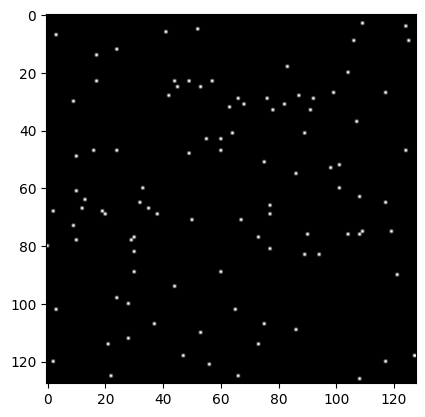

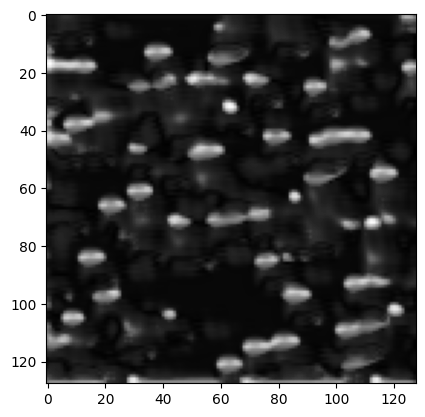

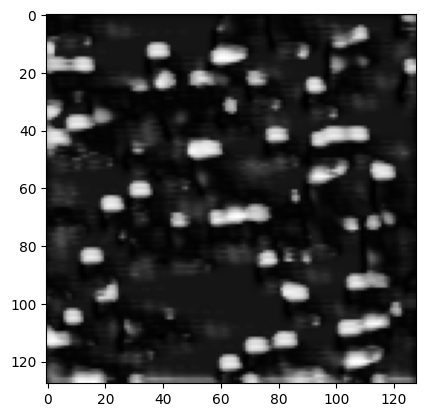

In [42]:
if dataset == "mazes":
    plt.imshow(sample_test.x.squeeze()[:3].permute(1, 2, 0))
    plt.show()
    plt.imshow(sample_test.x.squeeze()[3], cmap="gray")
    plt.show()
    plt.imshow(sample_test.h_pyrs[-1].squeeze()[-1].sum(dim=0), cmap="gray")
    plt.show()
    plt.imshow(sample_test.h_inters[-1].squeeze()[-1].sum(dim=0), cmap="gray")
    plt.show()
elif dataset == "correlated_dots":
    plt.imshow(sample_test.x.squeeze()[-1], cmap="gray")
    plt.show()
    plt.imshow(sample_test.h_pyrs[-1].squeeze()[-1].sum(dim=0), cmap="gray")
    plt.show()
    plt.imshow(sample_test.h_inters[-1].squeeze()[-1].sum(dim=0), cmap="gray")
    plt.show()

In [43]:
for i, sample in df.iterrows():
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create partial function for updating the frame
    if dataset == "mazes":
        update = update_frame_mazes
    elif dataset == "correlated_dots":
        update = update_frame_correlated_dots
    update = partial(
        update,
        ax=ax,
        sample=sample,
        transform=transform,
        alpha_x=alpha_x,
        alpha_pyr=alpha_pyr,
        alpha_inter=alpha_inter,
    )

    # Create the animation
    update(0)
    anim = animation.FuncAnimation(
        fig, update, frames=num_frames, interval=1000 / fps, blit=False
    )

    # Save the animation as an MP4 file
    anim.save(
        os.path.join(save_dir, f"{dataset}_visualization_{i}.mp4"),
        writer="ffmpeg",
        fps=fps,
    )

    plt.close(fig)

    if debug:
        break

label_pred = df[["label", "pred"]].map(lambda x: x.item())
label_pred.to_csv(os.path.join(save_dir, "labels.csv"))

In [44]:
! tar -czvf {tar_path} {save_dir}

visualizations/correlated_dots/2024-12-19_02-55/
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_0.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_1.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_2.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_3.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_4.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_5.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_6.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_7.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_8.mp4
visualizations/correlated_dots/2024-12-19_02-55/correlated_dots_visualization_9.mp4
visualizations/correlated_dots/2024-12-19_02-55/labels.csv
